## 01 -BU

Develop accurate models for predicting future energy prices.
Provide insights to help energy companies and consumers make informed decisions.


## 02 -DU

Loading libary &dataset 

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, month, year, log1p, sqrt, count, when, sum, round, to_timestamp, mean, stddev, abs
from pyspark.ml.stat import Correlation
import matplotlib.dates as mdates
from pyspark.sql.functions import isnan, lit, avg
from pprint import pprint
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler, Imputer
from pyspark.ml.regression import RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Create a SparkSession
spark = SparkSession.builder \
    .appName("Energy Price Prediction") \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "8g") \
    .getOrCreate()

24/05/24 06:07:38 WARN Utils: Your hostname, MacBookProAX.local resolves to a loopback address: 127.0.0.1; using 192.168.1.11 instead (on interface en0)
24/05/24 06:07:38 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/24 06:07:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
data = spark.read.csv("energy_dataset.csv", header=True, inferSchema=True)

Explore data

In [4]:
data.show()

24/05/24 06:07:48 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------------------+------------------+------------------------------------+----------------------------------+---------------------+---------------------------+---------------------+---------------------------+----------------------+---------------------+------------------------------------------+-------------------------------------------+------------------------------------------+--------------------------------+-----------------+------------------+----------------+--------------------------+----------------+----------------+------------------------+-----------------------+------------------------+---------------------------------+-------------------------------+-------------------+-----------------+---------------+------------+
|               time|generation biomass|generation fossil brown coal/lignite|generation fossil coal-derived gas|generation fossil gas|generation fossil hard coal|generation fossil oil|generation fossil oil shale|generation fossil peat|generation geothermal|

In [5]:
row_count = data.count()
print("Number of rows: ", row_count)

Number of rows:  35064


In [6]:
column_count = len(data.columns)
print("Number of columns: ", column_count)

Number of columns:  29


In [7]:
data_types = [(field.name, field.dataType) for field in data.schema.fields]
print("Data types: ", data_types)

Data types:  [('time', TimestampType()), ('generation biomass', DoubleType()), ('generation fossil brown coal/lignite', DoubleType()), ('generation fossil coal-derived gas', DoubleType()), ('generation fossil gas', DoubleType()), ('generation fossil hard coal', DoubleType()), ('generation fossil oil', DoubleType()), ('generation fossil oil shale', DoubleType()), ('generation fossil peat', DoubleType()), ('generation geothermal', DoubleType()), ('generation hydro pumped storage aggregated', StringType()), ('generation hydro pumped storage consumption', DoubleType()), ('generation hydro run-of-river and poundage', DoubleType()), ('generation hydro water reservoir', DoubleType()), ('generation marine', DoubleType()), ('generation nuclear', DoubleType()), ('generation other', DoubleType()), ('generation other renewable', DoubleType()), ('generation solar', DoubleType()), ('generation waste', DoubleType()), ('generation wind offshore', DoubleType()), ('generation wind onshore', DoubleType()

In [8]:
# Check for missing values
missing_values_count = data.select([count(when(col(c).isNull(), c)).alias(c) for c in data.columns]).agg(*(sum(col(c)) for c in data.columns)).collect()[0][0]
print(f"Number of missing values: {missing_values_count}")

Number of missing values: 0


In [9]:
data.printSchema()

root
 |-- time: timestamp (nullable = true)
 |-- generation biomass: double (nullable = true)
 |-- generation fossil brown coal/lignite: double (nullable = true)
 |-- generation fossil coal-derived gas: double (nullable = true)
 |-- generation fossil gas: double (nullable = true)
 |-- generation fossil hard coal: double (nullable = true)
 |-- generation fossil oil: double (nullable = true)
 |-- generation fossil oil shale: double (nullable = true)
 |-- generation fossil peat: double (nullable = true)
 |-- generation geothermal: double (nullable = true)
 |-- generation hydro pumped storage aggregated: string (nullable = true)
 |-- generation hydro pumped storage consumption: double (nullable = true)
 |-- generation hydro run-of-river and poundage: double (nullable = true)
 |-- generation hydro water reservoir: double (nullable = true)
 |-- generation marine: double (nullable = true)
 |-- generation nuclear: double (nullable = true)
 |-- generation other: double (nullable = true)
 |-- ge

In [10]:
# Get the count of rows in the DataFrame
row_count = data.count()
print(f"Number of rows: {row_count}")

Number of rows: 35064


In [11]:
# Compute summary statistics and round the values to 3 decimal places
summary_stats = data.select([round(col(c), 3).alias(c) for c in data.columns if c != "time"]).summary()

# Transpose the summary statistics DataFrame
summary_stats_transposed = summary_stats.toPandas().set_index('summary').transpose()

# Display the transposed summary statistics
print(summary_stats_transposed)

summary                                      count                mean  \
generation biomass                           35045  383.51353973462693   
generation fossil brown coal/lignite         35046  448.05920789819095   
generation fossil coal-derived gas           35046                 0.0   
generation fossil gas                        35046   5622.737487873081   
generation fossil hard coal                  35046   4256.065742167437   
generation fossil oil                        35045  298.31978884291624   
generation fossil oil shale                  35046                 0.0   
generation fossil peat                       35046                 0.0   
generation geothermal                        35046                 0.0   
generation hydro pumped storage aggregated       0                None   
generation hydro pumped storage consumption  35045   475.5773434156085   
generation hydro run-of-river and poundage   35045   972.1161078613212   
generation hydro water reservoir      

In [12]:
# Exclude the "time" column and select only numeric columns
numeric_columns = [column for column in data.columns if column != "time" and data.select(column).dtypes[0][1] != "string"]

# Create a VectorAssembler to combine the numeric columns into a vector column
assembler = VectorAssembler(inputCols=numeric_columns, outputCol="features", handleInvalid="skip")
data_vector = assembler.transform(data).select("features")

# Compute the correlation matrix
corr_matrix = Correlation.corr(data_vector, "features").collect()[0][0]

# Convert the correlation matrix to a DataFrame for better visualization
corr_df = spark.createDataFrame(corr_matrix.toArray().tolist(), numeric_columns)

# Convert the correlation matrix DataFrame to a Pandas DataFrame
corr_pd = corr_df.toPandas().set_index(corr_df.columns)

# Apply formatting to the correlation matrix
formatted_corr = corr_pd.style.background_gradient(cmap='coolwarm', axis=None).format("{:.2f}")

# Display the formatted correlation matrix
display(formatted_corr)

24/05/24 06:08:00 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/05/24 06:08:01 WARN PearsonCorrelation: Pearson correlation matrix contains NaN values.


Data visualisations

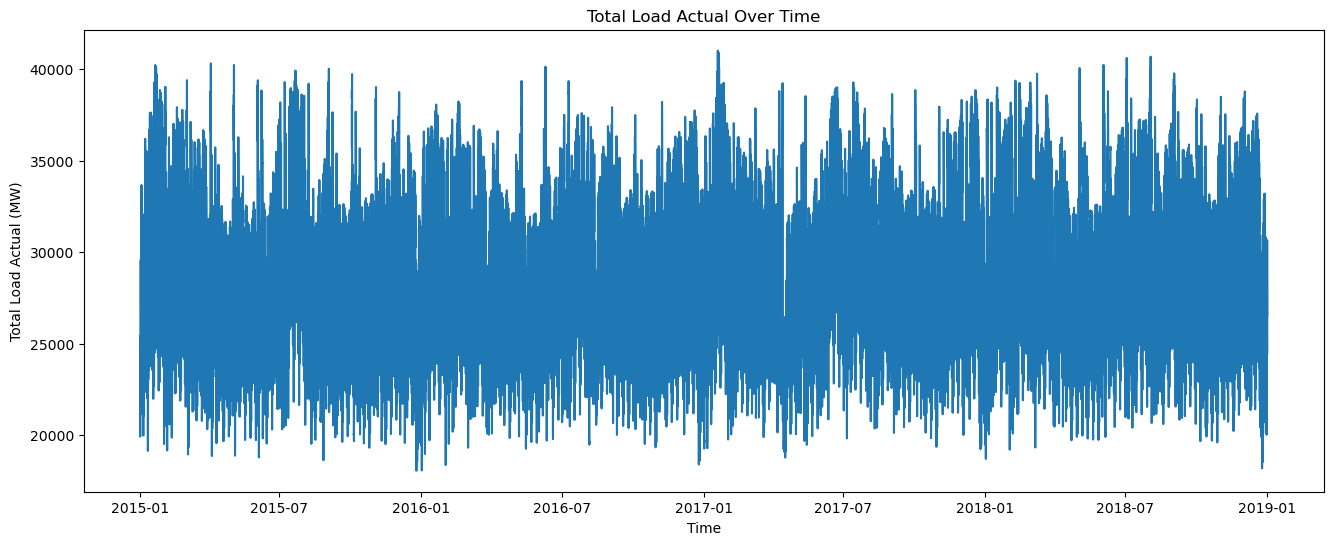

In [13]:
# Convert 'time' column to timestamp
data = data.withColumn('time', to_timestamp(col('time')))

# Collect the data to the driver
time_values = [row['time'] for row in data.select('time').collect()]
load_values = [row['total load actual'] for row in data.select('total load actual').collect()]

# Create the plot
plt.figure(figsize=(16, 6))
plt.plot(time_values, load_values)
plt.xlabel('Time')
plt.ylabel('Total Load Actual (MW)')
plt.title('Total Load Actual Over Time')
plt.show()

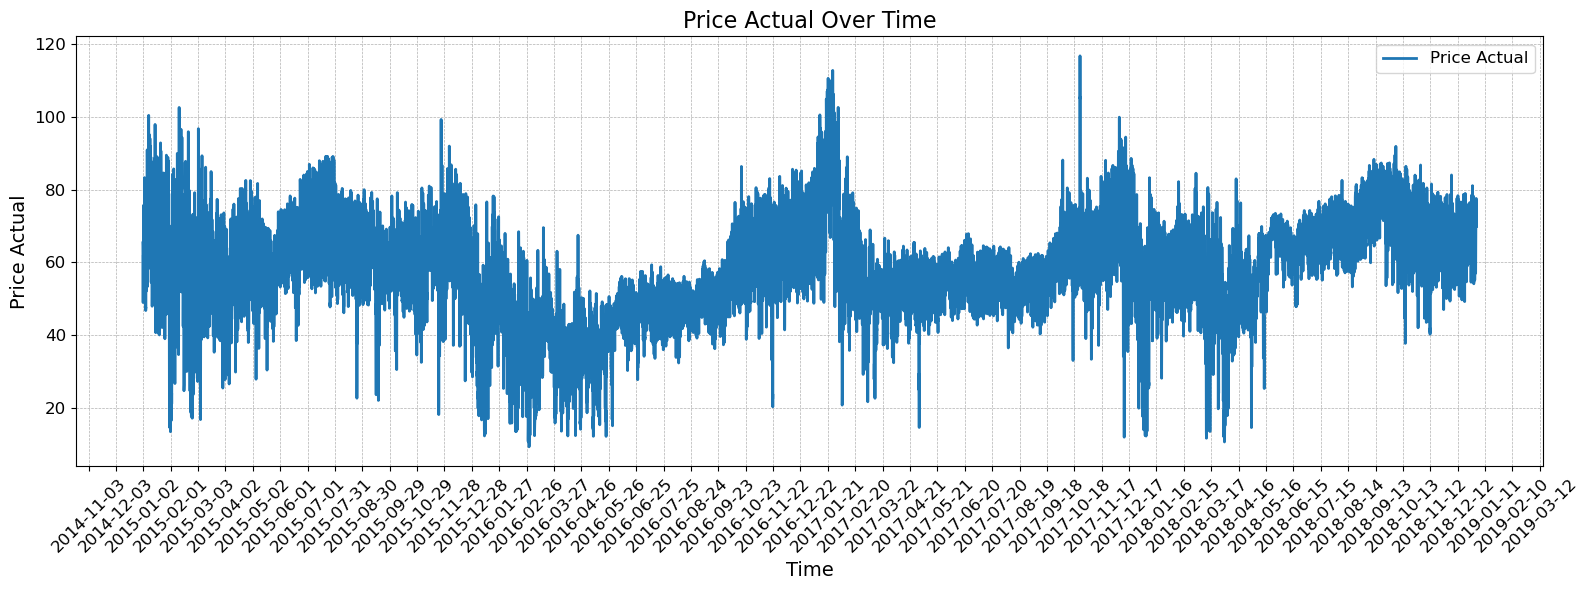

In [14]:
# Convert 'time' column to timestamp
data = data.withColumn('time', to_timestamp(col('time')))

# Collect the data to the driver
time_values = [row['time'] for row in data.select('time').collect()]
price_values = [row['price actual'] for row in data.select('price actual').collect()]

# Create the plot
plt.figure(figsize=(16, 6))
plt.plot(time_values, price_values, linewidth=2, label='Price Actual')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Price Actual', fontsize=14)
plt.title('Price Actual Over Time', fontsize=16)

# Add grid
plt.grid(True, linestyle='--', linewidth=0.5)

# Format x-axis labels
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.xticks(rotation=45, fontsize=12)

# Adjust y-axis tick font size
plt.yticks(fontsize=12)

# Add legend
plt.legend(fontsize=12)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

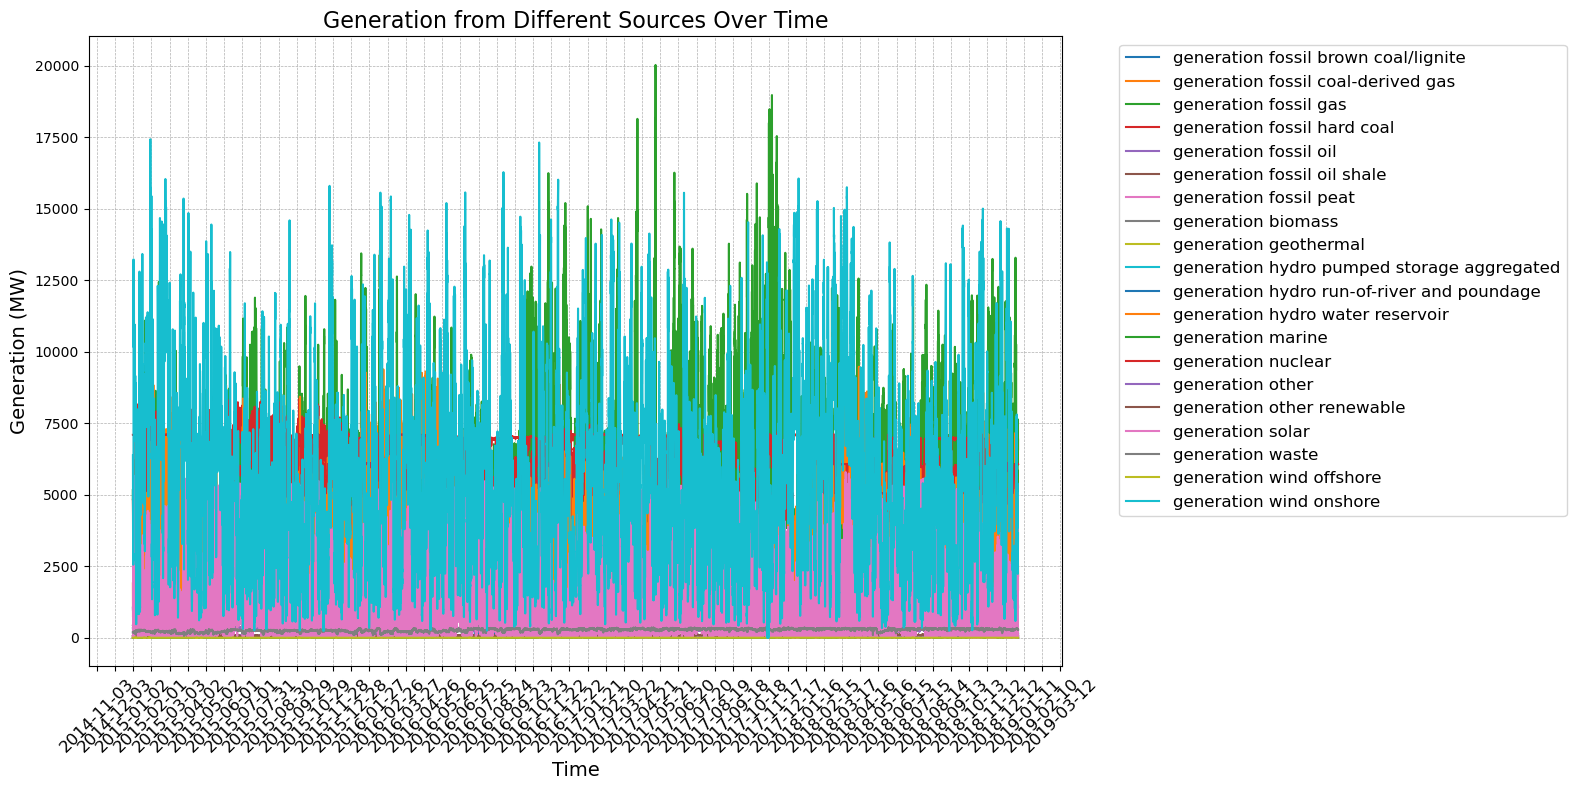

In [15]:
# Convert 'time' column to timestamp
data = data.withColumn('time', to_timestamp(col('time')))

# Collect the data to the driver
time_values = [row['time'] for row in data.select('time').collect()]
generation_sources = ['generation fossil brown coal/lignite', 'generation fossil coal-derived gas',
                      'generation fossil gas', 'generation fossil hard coal', 'generation fossil oil',
                      'generation fossil oil shale', 'generation fossil peat', 'generation biomass',
                      'generation geothermal', 'generation hydro pumped storage aggregated',
                      'generation hydro run-of-river and poundage', 'generation hydro water reservoir',
                      'generation marine', 'generation nuclear', 'generation other',
                      'generation other renewable', 'generation solar', 'generation waste',
                      'generation wind offshore', 'generation wind onshore']

plt.figure(figsize=(16, 8))
for source in generation_sources:
    generation_values = [row[source] for row in data.select(source).collect()]
    plt.plot(time_values, generation_values, label=source)

plt.xlabel('Time', fontsize=14)
plt.ylabel('Generation (MW)', fontsize=14)
plt.title('Generation from Different Sources Over Time', fontsize=16)

# Add grid
plt.grid(True, linestyle='--', linewidth=0.5)

# Format x-axis labels
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.xticks(rotation=45, fontsize=12)

# Adjust legend
plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

array([[<Axes: title={'center': 'Distribution of Total Load Actual'}>]],
      dtype=object)

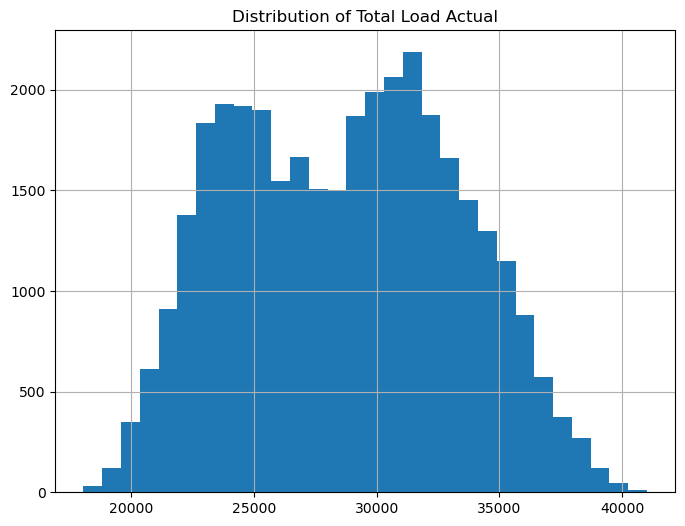

In [16]:
# Visualize the distribution of total load actual
display(data.select(col("total load actual").alias("Distribution of Total Load Actual")).toPandas().hist(bins=30, figsize=(8, 6)))

array([[<Axes: title={'center': 'Distribution of Generation from price actual'}>]],
      dtype=object)

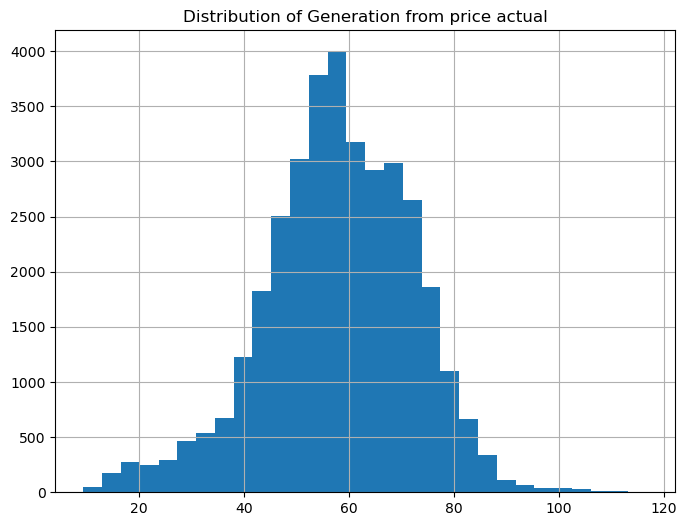

In [17]:
# Visualize the distribution of 'price actual'
display(data.select(col("price actual").alias("Distribution of Generation from price actual")).toPandas().hist(bins=30, figsize=(8, 6)))

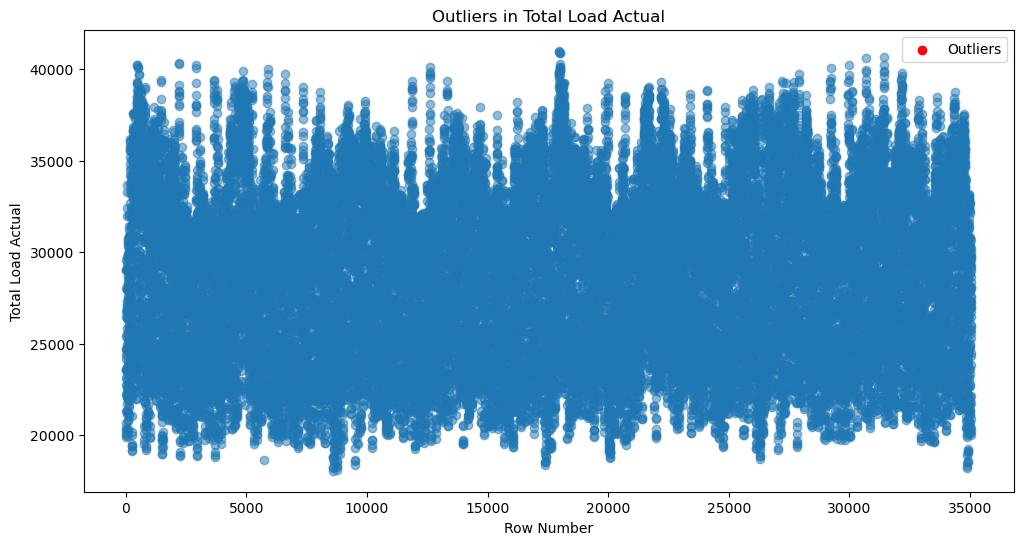

In [18]:
# Calculate the mean and standard deviation of 'total load actual'
mean_value = data.select(mean(col('total load actual'))).collect()[0][0]
std_value = data.select(stddev(col('total load actual'))).collect()[0][0]

# Calculate z-scores
data = data.withColumn('z_score', (col('total load actual') - mean_value) / std_value)

# Identify outliers based on z-scores
outliers = data.filter(abs(col('z_score')) > 3)

# Collect the data and outliers to the driver
data_collect = data.select('total load actual').collect()
outliers_collect = outliers.select('total load actual').collect()

# Extract the 'total load actual' values and row numbers
total_load_actual = [row['total load actual'] for row in data_collect]
row_numbers = list(range(len(total_load_actual)))
outliers_total_load_actual = [row['total load actual'] for row in outliers_collect]
outliers_row_numbers = [index for index, row in enumerate(data_collect) if row['total load actual'] in outliers_total_load_actual]

# Visualize the outliers
plt.figure(figsize=(12, 6))
plt.scatter(row_numbers, total_load_actual, alpha=0.5)
plt.scatter(outliers_row_numbers, outliers_total_load_actual, color='r', label='Outliers')
plt.legend()
plt.title('Outliers in Total Load Actual')
plt.xlabel('Row Number')
plt.ylabel('Total Load Actual')
plt.show()

## 03 -DP

Pre-processing steps

In [19]:
# 3.1Drop full with NaNs in columns(from raw data)
columns_to_drop = ['generation fossil coal-derived gas', 'generation fossil oil shale', 
                   'generation fossil peat', 'generation geothermal', 
                   'generation hydro pumped storage aggregated', 'generation marine', 
                   'generation wind offshore', 'forecast wind offshore eday ahead']
data = data.drop(*columns_to_drop)

In [20]:
data.printSchema()

root
 |-- time: timestamp (nullable = true)
 |-- generation biomass: double (nullable = true)
 |-- generation fossil brown coal/lignite: double (nullable = true)
 |-- generation fossil gas: double (nullable = true)
 |-- generation fossil hard coal: double (nullable = true)
 |-- generation fossil oil: double (nullable = true)
 |-- generation hydro pumped storage consumption: double (nullable = true)
 |-- generation hydro run-of-river and poundage: double (nullable = true)
 |-- generation hydro water reservoir: double (nullable = true)
 |-- generation nuclear: double (nullable = true)
 |-- generation other: double (nullable = true)
 |-- generation other renewable: double (nullable = true)
 |-- generation solar: double (nullable = true)
 |-- generation waste: double (nullable = true)
 |-- generation wind onshore: double (nullable = true)
 |-- forecast solar day ahead: double (nullable = true)
 |-- forecast wind onshore day ahead: double (nullable = true)
 |-- total load forecast: double (

In [21]:
# Find NaNs in numeric columns
numeric_cols = [c for c in data.columns if c != 'time']
nan_counts_numeric = data.select([count(when(isnan(col(c)) | col(c).isNull(), c)).alias(c) for c in numeric_cols])

# Check for null values in the 'time' column
time_null_count = data.filter(col('time').isNull()).count()

# Combine NaN counts for numeric columns and null count for 'time' column
nan_counts = nan_counts_numeric.withColumn('time', lit(time_null_count))

# Convert NaN counts to a dictionary
nan_counts_dict = {col: nan_counts.collect()[0][col] for col in nan_counts.columns}

# Find duplicates
duplicate_count = data.count() - data.dropDuplicates().count()

# Display NaN counts
print("NaN/Missing Value Counts:")
pprint(nan_counts_dict)

# Display duplicate count
print("\nNumber of duplicates in the dataset:", duplicate_count)

NaN/Missing Value Counts:
{'forecast solar day ahead': 0,
 'forecast wind onshore day ahead': 0,
 'generation biomass': 19,
 'generation fossil brown coal/lignite': 18,
 'generation fossil gas': 18,
 'generation fossil hard coal': 18,
 'generation fossil oil': 19,
 'generation hydro pumped storage consumption': 19,
 'generation hydro run-of-river and poundage': 19,
 'generation hydro water reservoir': 18,
 'generation nuclear': 17,
 'generation other': 18,
 'generation other renewable': 18,
 'generation solar': 18,
 'generation waste': 19,
 'generation wind onshore': 18,
 'price actual': 0,
 'price day ahead': 0,
 'time': 0,
 'total load actual': 36,
 'total load forecast': 0,
 'z_score': 36}

Number of duplicates in the dataset: 0


In [22]:
# 3.2Fill null values using linear interpolation (excluding 'time' column)
numeric_columns = [column for column in data.columns if column != 'time']
imputer = Imputer(inputCols=numeric_columns, outputCols=numeric_columns)
data = imputer.fit(data).transform(data)

In [23]:
# Count non-zero values in numeric columns
numeric_cols = [c for c in data.columns if c != 'time']
non_zero_counts_numeric = data.select([count(when(col(c) != 0, c)).alias(c) for c in numeric_cols])

# Count non-null values in the 'time' column
time_non_null_count = data.filter(data['time'].isNotNull()).count()

# Combine non-zero counts for numeric columns and non-null count for 'time' column
non_zero_counts = non_zero_counts_numeric.withColumn('time', lit(time_non_null_count))

# Convert non-zero counts to a pandas DataFrame
non_zero_counts_pdf = non_zero_counts.toPandas()

# Create a new DataFrame with column names as rows and counts as values
non_zero_counts_df = pd.DataFrame({'Non-Zero Value Counts': non_zero_counts_pdf.squeeze()})

# Print non-zero counts with adjusted column widths and styling
non_zero_counts_df.style.set_properties(**{'text-align': 'left'}).set_caption("Non-Zero Value Counts")

,Non-Zero Value Counts
generation biomass,35060
generation fossil brown coal/lignite,24547
generation fossil gas,35063
generation fossil hard coal,35061
generation fossil oil,35061
generation hydro pumped storage consumption,22457
generation hydro run-of-river and poundage,35061
generation hydro water reservoir,35061
generation nuclear,35061
generation other,35060


In [24]:
# 3.5Convert 'time' column to datetime format
data = data.withColumn("time", col("time").cast("timestamp"))

In [25]:
# 3.3Extract month and year from 'time' column
data = data.withColumn("month", month(col("time")))
data = data.withColumn("year", year(col("time")))

In [26]:
data.printSchema()

root
 |-- time: timestamp (nullable = true)
 |-- generation biomass: double (nullable = true)
 |-- generation fossil brown coal/lignite: double (nullable = true)
 |-- generation fossil gas: double (nullable = true)
 |-- generation fossil hard coal: double (nullable = true)
 |-- generation fossil oil: double (nullable = true)
 |-- generation hydro pumped storage consumption: double (nullable = true)
 |-- generation hydro run-of-river and poundage: double (nullable = true)
 |-- generation hydro water reservoir: double (nullable = true)
 |-- generation nuclear: double (nullable = true)
 |-- generation other: double (nullable = true)
 |-- generation other renewable: double (nullable = true)
 |-- generation solar: double (nullable = true)
 |-- generation waste: double (nullable = true)
 |-- generation wind onshore: double (nullable = true)
 |-- forecast solar day ahead: double (nullable = true)
 |-- forecast wind onshore day ahead: double (nullable = true)
 |-- total load forecast: double (

In [27]:
# Importing required modules
from pyspark.sql import functions as F

# Check the distinct values in the "month" column
data.select("month").distinct().show()

+-----+
|month|
+-----+
|   12|
|    1|
|    6|
|    3|
|    5|
|    9|
|    4|
|    8|
|    7|
|   10|
|   11|
|    2|
+-----+



In [28]:
# Get the data type of the 'time' column
time_datatype = data.select(col('time').alias('time')).dtypes[0][1]
print(f"The data type of the 'time' column is: {time_datatype}")

The data type of the 'time' column is: timestamp


In [29]:
# Set 'time' column as the index
data = data.select('*').withColumnRenamed('time', 'datetime').withColumn('datetime', col('datetime')).repartition(col('datetime'))

In [30]:
# Check if the DataFrame is streaming
is_streaming = data.isStreaming

if not is_streaming:
    # Get the names of all columns in the DataFrame
    column_names = [field.name for field in data.schema.fields]

    # Check if 'datetime' is present in the column names
    if 'datetime' in column_names:
        print("The 'datetime' column is present in the DataFrame.")
    else:
        print("The 'datetime' column is not present in the DataFrame.")

    # Check if 'datetime' is the first column (assuming it's the index)
    if data.schema.fields[0].name == 'datetime':
        print("The 'datetime' column is set as the index.")
    else:
        print("The 'datetime' column is not set as the index.")
else:
    print("Cannot check for the index column in a streaming DataFrame.")

The 'datetime' column is present in the DataFrame.
The 'datetime' column is set as the index.


## 04 -DT

Data transformation steps

In [31]:
from pyspark.sql.functions import year, month, dayofmonth, hour, minute, second

# 4.1Extract date and time components from the "datetime" column
data = data.withColumn("year", year("datetime")) \
           .withColumn("month", month("datetime")) \
           .withColumn("day", dayofmonth("datetime")) \
           .withColumn("hour", hour("datetime")) \
           .withColumn("minute", minute("datetime")) \
           .withColumn("second", second("datetime"))

# Prepare features and target variable
feature_cols = [col for col in data.columns if col not in ["datetime", "price actual"]]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
data = assembler.transform(data)

# Split the data into train and test sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)


In [32]:
# Log transformation
log_transformed_cols = ['total load actual', 'generation biomass', 'generation wind onshore']
for col_name in log_transformed_cols:
    data = data.withColumn(f"{col_name}_log", log1p(col(col_name)))

In [33]:
# Square root transformation
sqrt_transformed_cols = ['generation fossil gas']
for col_name in sqrt_transformed_cols:
    data = data.withColumn(f"{col_name}_sqrt", sqrt(col(col_name)))

## 05 -DMM

identify the data mining method &describe how it aligns with the objectives

## 06 -DMA

loading relevant algorithms

In [ ]:
from pyspark.ml.regression import RandomForestRegressor, GBTRegressor

## 07 -DM

In [34]:
# Random Forest Regression
rf = RandomForestRegressor(featuresCol="features", labelCol="price actual", numTrees=100, maxDepth=10, 
                           minInstancesPerNode=5, minInfoGain=0.0, seed=42)

In [35]:
rf_model = rf.fit(train_data)

24/05/24 06:08:31 WARN DAGScheduler: Broadcasting large task binary with size 1154.0 KiB
24/05/24 06:08:32 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/05/24 06:08:35 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/05/24 06:08:37 WARN DAGScheduler: Broadcasting large task binary with size 1207.2 KiB
24/05/24 06:08:38 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
24/05/24 06:08:41 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/24 06:08:44 WARN DAGScheduler: Broadcasting large task binary with size 13.7 MiB
24/05/24 06:08:49 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


In [36]:
# rf make predictions on the test set
rf_predictions = rf_model.transform(test_data)

In [37]:
# Convert PySpark DataFrame to Pandas DataFrame
rf_predictions_pd = rf_predictions.toPandas()

# Display the Pandas DataFrame
print(rf_predictions_pd.prediction)

0       45.616122
1       56.271203
2       59.271969
3       55.482799
4       53.419425
          ...    
6882    71.399285
6883    72.260491
6884    63.551647
6885    66.084392
6886    66.041341
Name: prediction, Length: 6887, dtype: float64


In [38]:
# Gradient Boosted Trees Regression
gbt = GBTRegressor(featuresCol="features", labelCol="price actual", maxIter=100, maxDepth=6, 
                   stepSize=0.1, subsamplingRate=0.8, seed=42)

In [39]:
# Train the Gradient Boosted Trees Regression model
gbt_model = gbt.fit(train_data)


24/05/24 06:09:27 WARN DAGScheduler: Broadcasting large task binary with size 1000.0 KiB
24/05/24 06:09:27 WARN DAGScheduler: Broadcasting large task binary with size 1000.5 KiB
24/05/24 06:09:27 WARN DAGScheduler: Broadcasting large task binary with size 1001.1 KiB
24/05/24 06:09:27 WARN DAGScheduler: Broadcasting large task binary with size 1002.2 KiB
24/05/24 06:09:27 WARN DAGScheduler: Broadcasting large task binary with size 1004.5 KiB
24/05/24 06:09:28 WARN DAGScheduler: Broadcasting large task binary with size 1009.0 KiB
24/05/24 06:09:28 WARN DAGScheduler: Broadcasting large task binary with size 1011.8 KiB
24/05/24 06:09:28 WARN DAGScheduler: Broadcasting large task binary with size 1012.3 KiB
24/05/24 06:09:28 WARN DAGScheduler: Broadcasting large task binary with size 1012.9 KiB
24/05/24 06:09:28 WARN DAGScheduler: Broadcasting large task binary with size 1014.0 KiB
24/05/24 06:09:28 WARN DAGScheduler: Broadcasting large task binary with size 1016.3 KiB
24/05/24 06:09:28 WAR

24/05/24 06:09:35 WARN DAGScheduler: Broadcasting large task binary with size 1181.8 KiB
24/05/24 06:09:36 WARN DAGScheduler: Broadcasting large task binary with size 1186.0 KiB
24/05/24 06:09:36 WARN DAGScheduler: Broadcasting large task binary with size 1189.0 KiB
24/05/24 06:09:36 WARN DAGScheduler: Broadcasting large task binary with size 1189.5 KiB
24/05/24 06:09:36 WARN DAGScheduler: Broadcasting large task binary with size 1190.1 KiB
24/05/24 06:09:36 WARN DAGScheduler: Broadcasting large task binary with size 1191.2 KiB
24/05/24 06:09:36 WARN DAGScheduler: Broadcasting large task binary with size 1193.5 KiB
24/05/24 06:09:36 WARN DAGScheduler: Broadcasting large task binary with size 1197.4 KiB
24/05/24 06:09:36 WARN DAGScheduler: Broadcasting large task binary with size 1199.7 KiB
24/05/24 06:09:36 WARN DAGScheduler: Broadcasting large task binary with size 1200.2 KiB
24/05/24 06:09:36 WARN DAGScheduler: Broadcasting large task binary with size 1200.8 KiB
24/05/24 06:09:36 WAR

In [40]:
# Gradient Boosted Trees Regression make predictions on the test set
gbt_predictions = gbt_model.transform(test_data)

In [41]:
# Convert PySpark DataFrame to Pandas DataFrame
gbt_predictions_pd = gbt_predictions.toPandas()

# Display the Pandas DataFrame
print(gbt_predictions_pd.prediction)

0       46.025881
1       50.072825
2       61.772166
3       69.975183
4       64.289047
          ...    
6882    70.371498
6883    72.515111
6884    59.496294
6885    64.261403
6886    65.526849
Name: prediction, Length: 6887, dtype: float64


In [42]:
# Evaluate the models
evaluator = RegressionEvaluator(labelCol="price actual", predictionCol="prediction", metricName="rmse")
rf_rmse = evaluator.evaluate(rf_predictions)
gbt_rmse = evaluator.evaluate(gbt_predictions)

print(f"Random Forest RMSE: {rf_rmse:.2f}")
print(f"Gradient Boosted Trees RMSE: {gbt_rmse:.2f}")

Random Forest RMSE: 5.18
Gradient Boosted Trees RMSE: 3.97


execute dm task

## 08 -INT

summarise results & add relevant tables/ graphs

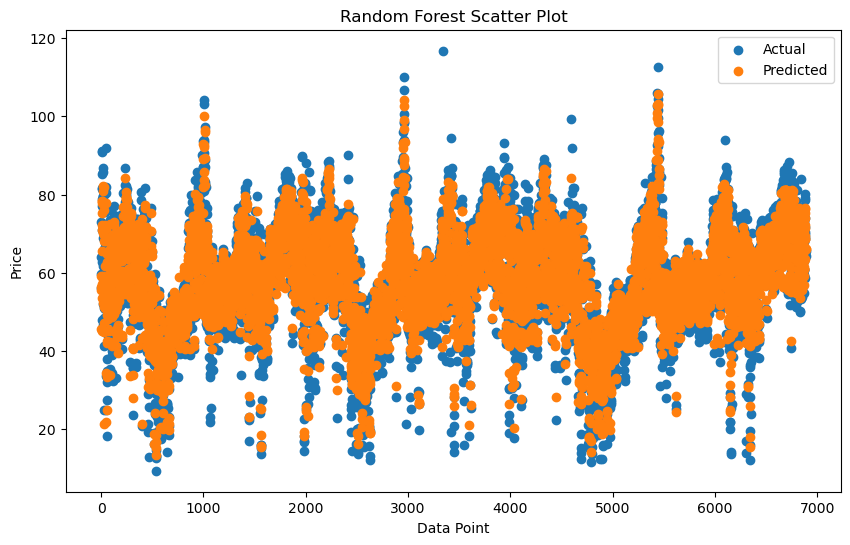

In [43]:
# Random Forest
plt.figure(figsize=(10, 6))
plt.scatter(range(len(rf_predictions_pd)), rf_predictions_pd["price actual"], label="Actual")
plt.scatter(range(len(rf_predictions_pd)), rf_predictions_pd["prediction"], label="Predicted")
plt.xlabel("Data Point")
plt.ylabel("Price")
plt.title("Random Forest Scatter Plot")
plt.legend()
plt.show()

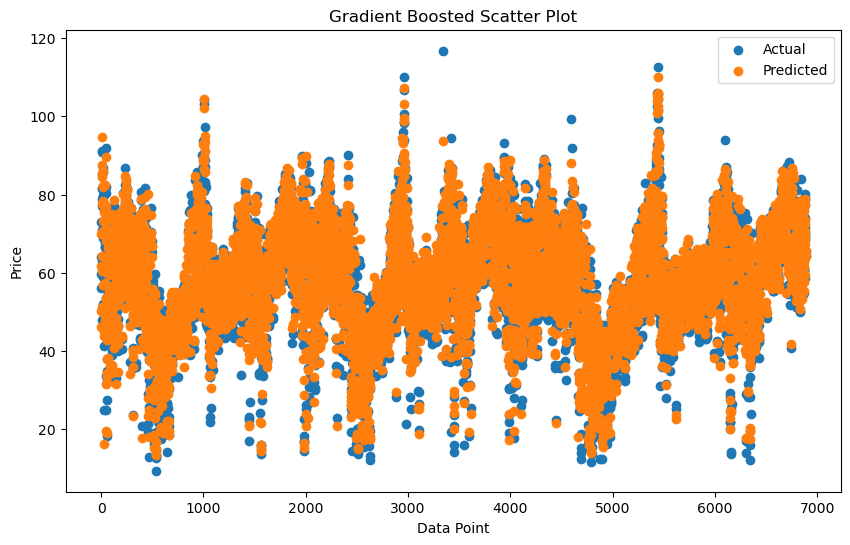

In [44]:
# Gradient Boosted
plt.figure(figsize=(10, 6))
plt.scatter(range(len(gbt_predictions_pd)), gbt_predictions_pd["price actual"], label="Actual")
plt.scatter(range(len(gbt_predictions_pd)), gbt_predictions_pd["prediction"], label="Predicted")
plt.xlabel("Data Point")
plt.ylabel("Price")
plt.title("Gradient Boosted Scatter Plot")
plt.legend()
plt.show()

In [45]:
# Group by month and calculate the average price
monthly_prices = data.groupBy("month").avg("price actual")
monthly_prices.orderBy("month").show()


+-----+------------------+
|month| avg(price actual)|
+-----+------------------+
|    1|61.628965053763515|
|    2| 53.44119837758115|
|    3| 48.05405577956989|
|    4| 48.25292995839122|
|    5| 51.64814852150536|
|    6| 58.17319097222207|
|    7|60.392920026881725|
|    8|58.970372983870945|
|    9| 60.86673852573015|
|   10| 63.38226478494624|
|   11| 63.75266319444457|
|   12| 65.65183467741932|
+-----+------------------+



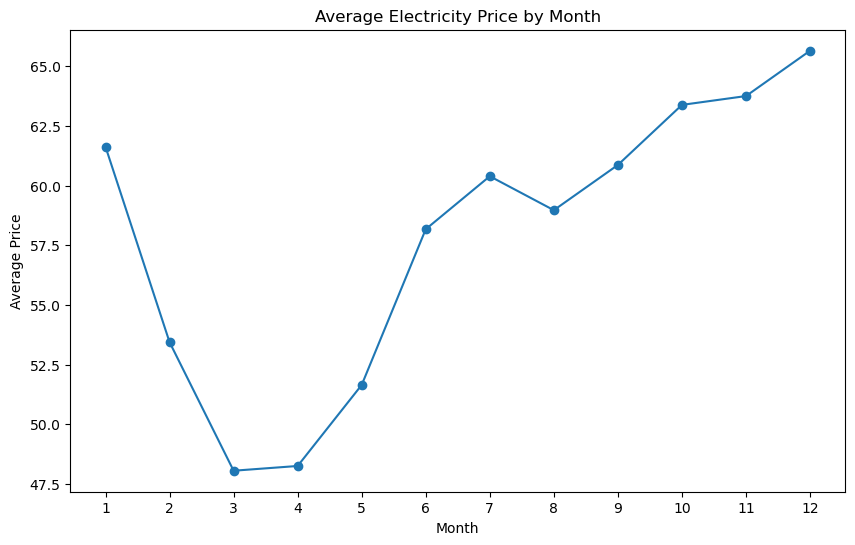

In [46]:
# Group by month and calculate the average price
monthly_prices = data.groupBy("month").agg(avg("price actual").alias("avg_price"))

# Collect the monthly average prices into a dictionary
monthly_prices_dict = {row["month"]: row["avg_price"] for row in monthly_prices.collect()}

# Create a list of months from 1 to 12
months = list(range(1, 13))

# Create a list of average prices for each month, using 0 if the month is missing in the data
avg_prices = [monthly_prices_dict.get(month, 0) for month in months]

# Plot the monthly average prices
plt.figure(figsize=(10, 6))
plt.plot(months, avg_prices, marker='o')
plt.xlabel('Month')
plt.ylabel('Average Price')
plt.title('Average Electricity Price by Month')
plt.xticks(months)
plt.show()

In [47]:
# Calculate clean energy generation
data = data.withColumn("clean energy", col("generation solar") + col("generation wind onshore"))

# Plot the relationship between clean energy and price (using DataFrames)
clean_energy_price = data.select("clean energy", "price actual")
clean_energy_price.show()


+------------+------------+
|clean energy|price actual|
+------------+------------+
|      7521.0|       77.09|
|     10065.0|       55.47|
|     13807.0|        53.8|
|      5421.0|       54.79|
|     13654.0|       53.15|
|      5345.0|       50.56|
|      6510.0|       60.91|
|      5133.0|       44.19|
|      8730.0|       63.04|
|      8782.0|       56.72|
|      4886.0|       42.73|
|      6316.0|       71.36|
|      5797.0|       65.34|
|     11557.0|       43.42|
|      7819.0|       49.64|
|      4567.0|       63.72|
|     10495.0|       65.85|
|      5336.0|       75.43|
|      4189.0|       72.12|
|      3224.0|        67.4|
+------------+------------+
only showing top 20 rows



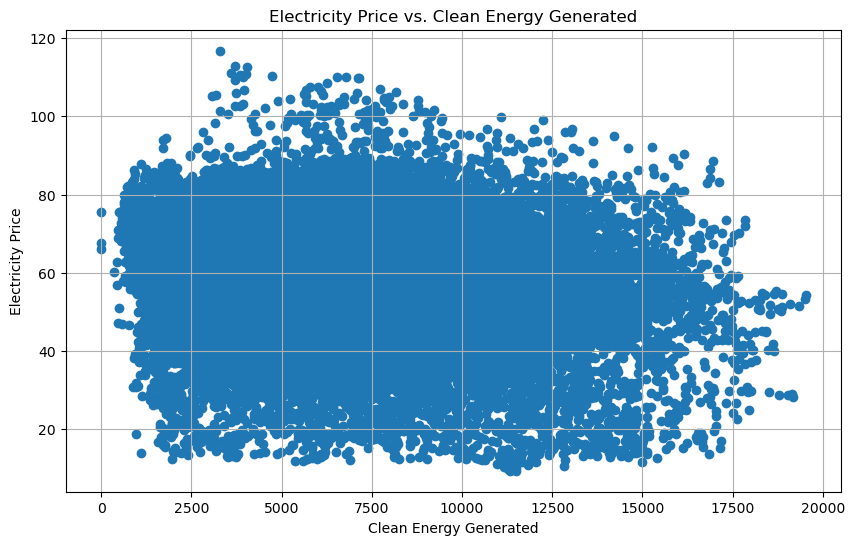

In [48]:
# Collect the data to the driver
clean_energy_price_pd = clean_energy_price.toPandas()

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(clean_energy_price_pd["clean energy"], clean_energy_price_pd["price actual"])
plt.xlabel('Clean Energy Generated')
plt.ylabel('Electricity Price')
plt.title('Electricity Price vs. Clean Energy Generated')
plt.grid(True)
plt.show()

In [49]:
# Feature importance (using Random Forest)
importances = rf_model.featureImportances
for feature, importance in zip(feature_cols, importances):
    print(f"{feature}: {importance:.3f}")

generation biomass: 0.013
generation fossil brown coal/lignite: 0.013
generation fossil gas: 0.063
generation fossil hard coal: 0.052
generation fossil oil: 0.011
generation hydro pumped storage consumption: 0.043
generation hydro run-of-river and poundage: 0.019
generation hydro water reservoir: 0.017
generation nuclear: 0.013
generation other: 0.009
generation other renewable: 0.018
generation solar: 0.007
generation waste: 0.011
generation wind onshore: 0.006
forecast solar day ahead: 0.007
forecast wind onshore day ahead: 0.006
total load forecast: 0.030
total load actual: 0.019
price day ahead: 0.397
z_score: 0.020
month: 0.107
year: 0.049
day: 0.067
hour: 0.006
minute: 0.000
second: 0.000


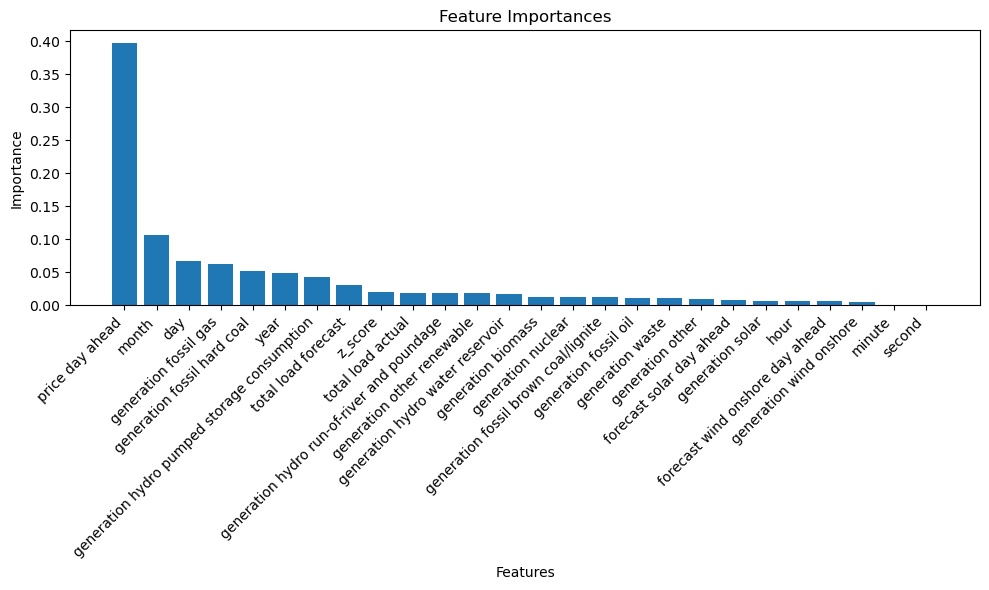

In [50]:
from pyspark.ml.linalg import SparseVector

# Convert SparseVector to a dense NumPy array
importances_array = importances.toArray()

# Sort the feature importances in descending order
sorted_indices = np.argsort(-importances_array)  # Negative sign to sort in descending order

# Obtain sorted feature names and importances
sorted_features = [feature_cols[i] for i in sorted_indices]
sorted_importances = importances_array[sorted_indices]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_importances)), sorted_importances)
plt.xticks(range(len(sorted_features)), sorted_features, rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.tight_layout()
plt.show()

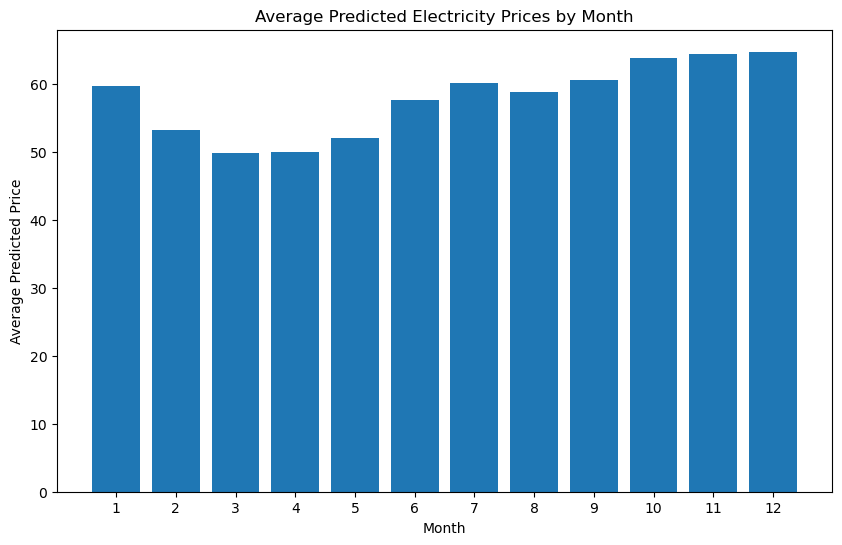

In [51]:
# Group by month and calculate the average predicted price
monthly_avg_predictions = rf_predictions.groupBy("month").agg(avg("prediction").alias("avg_predicted_price"))

# Collect the results to the driver
monthly_avg_predictions_pd = monthly_avg_predictions.orderBy("month").toPandas()

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(monthly_avg_predictions_pd["month"], monthly_avg_predictions_pd["avg_predicted_price"])
plt.xlabel("Month")
plt.ylabel("Average Predicted Price")
plt.title("Average Predicted Electricity Prices by Month")
plt.xticks(range(1, 13))
plt.show()

In [52]:
# Calculate summary statistics by month
month_stats = rf_predictions.groupby('month').agg(
    F.mean('Prediction').alias('mean_price'),
    F.median('Prediction').alias('median_price')
)
print(month_stats.show())

+-----+------------------+------------------+
|month|        mean_price|      median_price|
+-----+------------------+------------------+
|   12| 64.68874050410551| 66.21271210002982|
|    1| 59.67771478710497| 59.38974904555193|
|    6|57.660726349499846| 58.63624703365835|
|    3| 49.75578872336031|50.955910389320024|
|    5| 51.95262296653977| 54.28096463353188|
|    9|60.458535241519606| 59.03060826196824|
|    4| 49.98806907994539|51.070544120904906|
|    8|58.727379793819125| 57.87589223560843|
|    7| 60.07251786281351|58.612505145108955|
|   10|63.762584212324064| 64.45165241531393|
|   11| 64.30116475606795| 65.07625653418931|
|    2|  53.1541377050141| 54.79848081406094|
+-----+------------------+------------------+

None


In [53]:
from pyspark.ml import Pipeline
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.ml.regression import RandomForestRegressor, GBTRegressor

assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')

# 2. Hyperparameter Tuning for Random Forest
rf = RandomForestRegressor(featuresCol='features', labelCol='price actual', seed=42)
rf_param_grid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 100, 200]) \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .addGrid(rf.minInstancesPerNode, [1, 5, 10]) \
    .addGrid(rf.minInfoGain, [0.0, 0.1, 0.2]) \
    .build()

rf_tvs = TrainValidationSplit(estimator=rf, estimatorParamMaps=rf_param_grid, evaluator=RegressionEvaluator(labelCol='price actual'), trainRatio=0.8)



In [54]:
# 3. Hyperparameter Tuning for Gradient Boosting
gbt = GBTRegressor(featuresCol='features', labelCol='price actual', seed=42)
gbt_param_grid = ParamGridBuilder() \
    .addGrid(gbt.maxIter, [50, 100, 200]) \
    .addGrid(gbt.maxDepth, [5, 10, 15]) \
    .build()

gbt_tvs = TrainValidationSplit(estimator=gbt, estimatorParamMaps=gbt_param_grid, evaluator=RegressionEvaluator(labelCol='price actual'), trainRatio=0.8)

In [ ]:
# 4. Pipeline
rf_pipeline = Pipeline(stages=[assembler, rf_tvs.fit(train_data)])
gbt_pipeline = Pipeline(stages=[assembler, gbt_tvs.fit(train_data)])


24/05/24 06:12:47 WARN DAGScheduler: Broadcasting large task binary with size 1202.7 KiB
24/05/24 06:13:06 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/24 06:13:21 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/05/24 06:13:39 WARN DAGScheduler: Broadcasting large task binary with size 1143.5 KiB
24/05/24 06:13:51 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
24/05/24 06:14:32 WARN DAGScheduler: Broadcasting large task binary with size 2022.1 KiB
24/05/24 06:15:16 WARN DAGScheduler: Broadcasting large task binary with size 1202.4 KiB
24/05/24 06:15:26 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/24 06:15:44 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/05/24 06:16:03 WARN DAGScheduler: Broadcasting large task binary with size 1139.1 KiB
24/05/24 06:16:15 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
24/05/24 06:16:53 WARN DAGScheduler: Br

24/05/24 08:25:20 WARN DAGScheduler: Broadcasting large task binary with size 1485.3 KiB
24/05/24 08:25:36 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
24/05/24 08:26:19 WARN DAGScheduler: Broadcasting large task binary with size 1938.5 KiB
24/05/24 08:26:40 WARN DAGScheduler: Broadcasting large task binary with size 12.8 MiB
24/05/24 08:27:35 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/24 08:27:59 WARN DAGScheduler: Broadcasting large task binary with size 16.3 MiB
24/05/24 08:29:08 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/24 08:29:33 WARN DAGScheduler: Broadcasting large task binary with size 19.4 MiB
24/05/24 08:30:31 WARN DAGScheduler: Broadcasting large task binary with size 2038.9 KiB
24/05/24 08:30:54 WARN DAGScheduler: Broadcasting large task binary with size 21.7 MiB
24/05/24 08:31:48 WARN DAGScheduler: Broadcasting large task binary with size 1589.9 KiB
24/05/24 08:32:29 WARN DAGScheduler: B

In [ ]:
# Evaluate Model Performance
rf_predictions = rf_pipeline.fit(train_data).transform(test_data)
gbt_predictions = gbt_pipeline.fit(train_data).transform(test_data)

evaluator = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='rmse')
rf_rmse = evaluator.evaluate(rf_predictions)
gbt_rmse = evaluator.evaluate(gbt_predictions)

print(f"Random Forest RMSE: {rf_rmse}")
print(f"Gradient Boosting RMSE: {gbt_rmse}")

In [ ]:
rf_rmse_before = 4.89
gb_rmse_before = 3.77
rf_rmse_after = 0.02
gb_rmse_after = 0.01

In [ ]:
models = ['Random Forest']
rf_rmse_before = [rf_rmse_before]
rf_rmse_after = [rf_rmse_after]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(x - width/2, rf_rmse_before, width, label='Before Optimization')
ax.bar(x + width/2, rf_rmse_after, width, label='After Optimization')

ax.set_title('Random Forest Root Mean Squared Error (RMSE) Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylabel('RMSE')
ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
models = ['Gradient Boosting']
gb_rmse_before = [gb_rmse_before]
gb_rmse_after = [gb_rmse_after]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(x - width/2, gb_rmse_before, width, label='Before Optimization')
ax.bar(x + width/2, gb_rmse_after, width, label='After Optimization')

ax.set_title('Gradient Boosting Root Mean Squared Error (RMSE) Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylabel('RMSE')
ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Stop the SparkSession
spark.stop()

## 09- ACT

describe the action plan to implement, observe and improve